#### Analysis of muscimol data
Data needs to be grouped using 'Bpod_Analysis_MergeAnimals' before

In [2]:
%load_ext autoreload
%autoreload 2
from utils import plot_utils, Lapse_model
from utils import custom_functions as cuf

import os
import sys
#sys.path.append("../") # go to parent 
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
from itertools import chain

warnings.filterwarnings('ignore')

In [3]:
# path to the dataset
data_directory = cuf.get_data_folder() + '/Behavioural_Data/Bpod_data/Muscimol_Analysis/'
# dataframe name
df_name = 'Muscimol_dataframe.pkl'

# Read the dataframe
AnimalsDF = pd.read_pickle(data_directory + df_name)

In [4]:
# name your dataset for plotting
df_to_plot = AnimalsDF

In [5]:
# get if the previous trial was a success. 
# THIS SIMPLE WAY WILL NOT BE VALID FOR THE FIRST TRIAL OF EACH ANIMAL
df_to_plot['PrevTrialSuccess'] = np.insert(np.array(df_to_plot['FirstPokeCorrect'][:-1]), 0, np.nan)

Progress: [####################] 100.0%


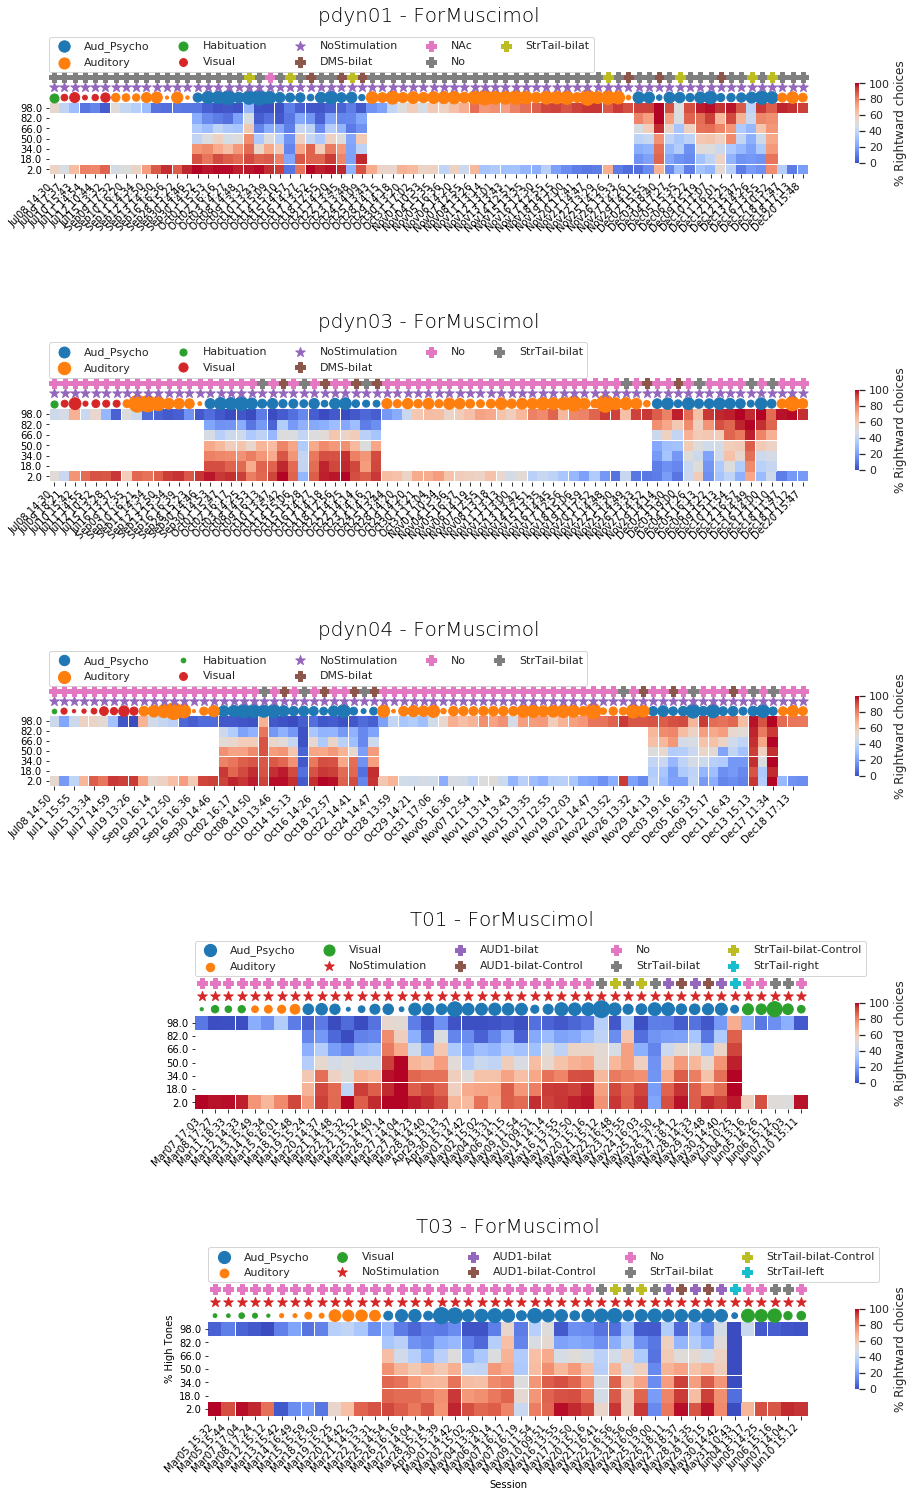

In [6]:
# plot a summary of all the animals in the dataset
fig, ax = plt.subplots(len(pd.unique(df_to_plot.AnimalID)), 1, figsize=(17,5 * len(pd.unique(df_to_plot.AnimalID))))
axs = ax.ravel()
fig.subplots_adjust(hspace=1.3)
for i, animal in enumerate(pd.unique(df_to_plot.AnimalID)):
    aDF = df_to_plot[df_to_plot.AnimalID == animal]
    dfToPlot = plot_utils.summary_matrix(aDF)
    axs[i] = plot_utils.summary_plot(dfToPlot, aDF, axs[i])
plt.savefig(data_directory + 'psychometricPerformanceSessionsAnalyzedHeatmap.pdf', transparent=True, bbox_inches='tight')    
plt.show(fig)

In [42]:
#Select conditions

# remove the trials at the beginning of the session
condition4 = AnimalsDF['TrialIndex'] > 10
conditions = condition4

# select only some protocols
prot_to_select = ['Aud_Psycho']
condition6 = AnimalsDF.Protocol.isin(prot_to_select)
conditions = np.logical_and(conditions, condition6)

df_to_plot = AnimalsDF[conditions]

In [20]:
# Use this to see the session IDs for a particular animal and select the ones you want
df_to_plot[df_to_plot.AnimalID == 'T03'].SessionID.unique()

array(['T03 May16 13:55', 'T03 May17 13:50', 'T03 May20 15:16',
       'T03 May21 16:41', 'T03 May22 16:56', 'T03 May23 13:56',
       'T03 May24 16:06', 'T03 May25 13:00', 'T03 May26 18:11',
       'T03 May27 18:37', 'T03 May28 14:35', 'T03 May29 16:15',
       'T03 May30 14:42', 'T03 May31 10:43'], dtype=object)

In [43]:
# select particular sessions to keep
sessionIDs_tokeep = ['pdyn01 Sep30 14:46', 'pdyn01 Sep30 14:52',
       'pdyn01 Oct01 15:53', 'pdyn01 Oct02 16:16', 'pdyn01 Oct03 14:27',
       'pdyn01 Oct08 14:48', 'pdyn01 Oct09 13:32', 'pdyn01 Oct10 13:43',
       'pdyn01 Oct11 15:09', 'pdyn01 Oct14 15:10', 'pdyn01 Oct15 14:57',
       'pdyn01 Oct16 14:27', 'pdyn01 Oct17 13:52', 'pdyn01 Oct18 12:55',
       'pdyn01 Oct21 14:20', 'pdyn01 Oct22 13:45', 'pdyn01 Oct23 13:48',
       'pdyn01 Oct24 14:09', 'pdyn03 Sep30 14:46',
       'pdyn03 Sep30 14:53', 'pdyn03 Oct01 15:47', 'pdyn03 Oct02 16:17',
       'pdyn03 Oct03 14:25', 'pdyn03 Oct08 14:53', 'pdyn03 Oct09 16:13',
       'pdyn03 Oct10 13:47', 'pdyn03 Oct11 15:42', 'pdyn03 Oct14 15:06',
       'pdyn03 Oct15 15:28', 'pdyn03 Oct16 14:27', 'pdyn03 Oct17 14:18',
       'pdyn03 Oct18 12:56', 'pdyn03 Oct21 14:25', 'pdyn03 Oct22 14:14',
       'pdyn03 Oct23 14:16', 'pdyn03 Oct24 14:32', 'pdyn04 Oct01 15:50',
       'pdyn04 Oct02 16:17', 'pdyn04 Oct03 14:25', 'pdyn04 Oct08 14:50',
       'pdyn04 Oct09 16:42', 'pdyn04 Oct10 13:46', 'pdyn04 Oct11 16:32',
       'pdyn04 Oct14 15:13', 'pdyn04 Oct15 16:13', 'pdyn04 Oct16 14:26',
       'pdyn04 Oct17 14:58', 'pdyn04 Oct18 12:57', 'pdyn04 Oct21 14:25',
       'pdyn04 Oct22 14:41', 'pdyn04 Oct23 14:43', 'pdyn04 Oct24 14:47',
       'T01 May16 13:55', 'T01 May17 13:50', 'T01 May20 15:16',
       'T01 May21 15:12', 'T01 May22 16:48', 'T01 May23 13:55',
       'T01 May24 16:03', 'T01 May25 12:50', 'T01 May26 17:54',
       'T01 May27 18:12', 'T01 May28 14:33', 'T01 May29 15:48',
       'T01 May30 14:40', 'T01 May31 10:25', 'T03 May16 13:55', 'T03 May17 13:50', 'T03 May20 15:16',
       'T03 May21 16:41', 'T03 May22 16:56', 'T03 May23 13:56',
       'T03 May24 16:06', 'T03 May25 13:00', 'T03 May26 18:11',
       'T03 May27 18:37', 'T03 May28 14:35', 'T03 May29 16:15',
       'T03 May30 14:42', 'T03 May31 10:43'
    
]


df_to_plot = df_to_plot[(df_to_plot['SessionID'].isin(sessionIDs_tokeep))]

In [44]:
# analyze the time they spend per sessions (some of them I have allowed recovery) TODO
# TrialStartTimestamp contains information about the trial time after the start of the session

# restrict the count to 1.5 hours
hours_cut_off = 1.5
df_to_plot = df_to_plot[df_to_plot['TrialStartTimestamp'] < hours_cut_off * 60 * 60]

In [26]:
# types of muscimol
df_to_plot.Muscimol.unique()

array(['No', 'StrTail-bilat', 'NAc', 'DMS-bilat', 'StrTail-bilat-Control',
       'AUD1-bilat', 'AUD1-bilat-Control', 'StrTail-right',
       'StrTail-left'], dtype=object)

In [45]:
# select which types to analyze
muscimol_tokeep = ['No', 'StrTail-bilat', 'DMS-bilat', 'StrTail-bilat-Control', 'AUD1-bilat', 'AUD1-bilat-Control']
df_to_plot = df_to_plot[df_to_plot['Muscimol'].isin(muscimol_tokeep)]

Progress: [####################] 100.0%


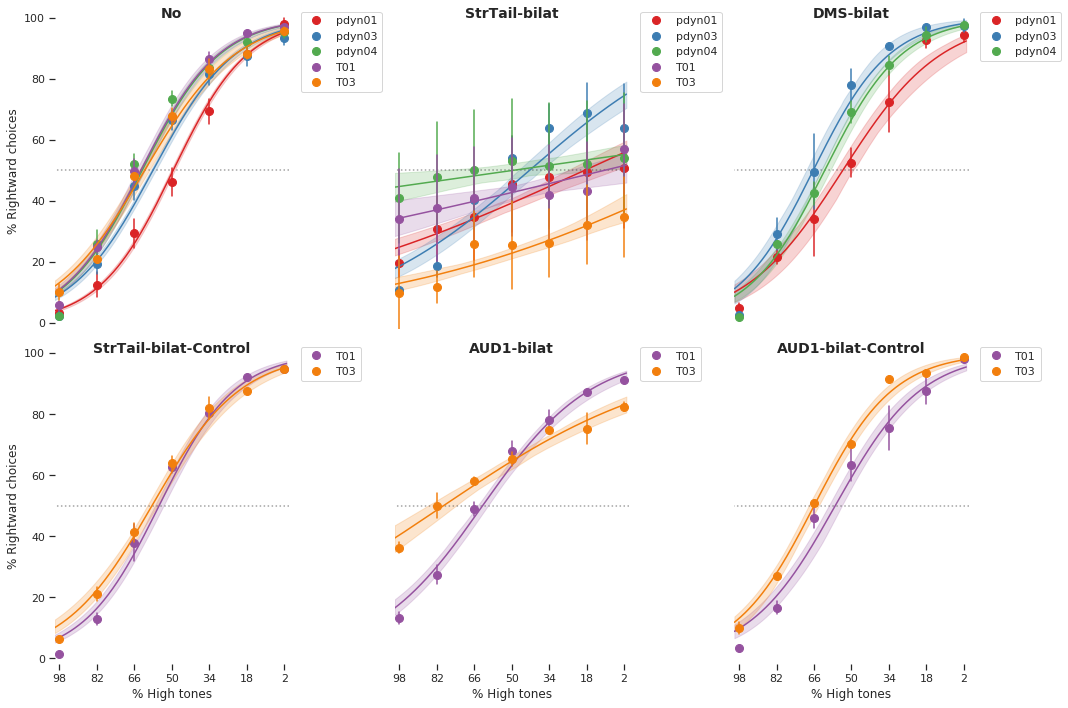

In [28]:
# plot psychometric curves

# prepare colors
my_palette = "Set1"
AnimalList = list(df_to_plot.AnimalID.unique())
ColorList = sns.color_palette(my_palette, n_colors=len(AnimalList), desat=.9)

fig, axs = plt.subplots(2, math.ceil(len(df_to_plot.Muscimol.unique())/2), figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.2, wspace=2)
axs = axs.ravel()
for ax in axs:
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)

for counter, muscimol_condition in enumerate(df_to_plot.Muscimol.unique()):
    ax = axs[counter]
    ax.text(50, 100, muscimol_condition, horizontalalignment='center', fontsize=14, fontweight='bold')
    for animal in df_to_plot[df_to_plot.Muscimol == muscimol_condition].AnimalID.unique():
        conditions = (df_to_plot['AnimalID'] == animal) & (df_to_plot['Muscimol'] == muscimol_condition)
        predictDif, PsyPer, fakePredictions, predictPer, EB = \
        cuf.PP_ProcessExperiment(df_to_plot[conditions], 50, error_bars='SessionTime')
        plot_utils.PlotPsychPerformance(dataDif=PsyPer['Difficulty'], dataPerf=PsyPer['Performance'],
                                        predictDif=predictDif, ax=ax, fakePred=fakePredictions,
                                        realPred=predictPer, label=animal, errorBars=EB,
                                        color=ColorList[AnimalList.index(animal)])
        
    #ax.get_legend().remove()
    ax.axis('on')
    # remove some ticks
    ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                   labelleft='on', labelbottom='on')
    if not ax.is_first_col():
        ax.set_ylabel('')
        ax.set_yticks([])
    if not ax.is_last_row():
        ax.set_xlabel('')
        ax.set_xticks([])
    plt.tight_layout()

    update_progress(counter / len(df_to_plot.Muscimol.unique()))
    
update_progress(1)
plt.savefig(data_directory + 'psychometricPerformance_byMuscimol.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [276]:
# fit a model to each session, extract the parameters, and compare those

# create empty df
coefs_df = pd.DataFrame(columns=['AnimalID', 'SessionID', 'Muscimol', 'Coef', 'Intercept', 'Cs'])

for session in df_to_plot.SessionID.unique():
    df = df_to_plot[df_to_plot.SessionID == session]
    # calculate the psych
    predictDif, PsyPer, fakePredictions, predictPer, _ = cuf.PP_ProcessExperiment(df, None)

    coefs_df = coefs_df.append({
                                'AnimalID': df.AnimalID.unique()[0],
                                'SessionID': session,
                                'Muscimol': df.Muscimol.unique()[0],
                                'Coef': PsyPer['Logit'].coef_[0][0],
                                'Intercept': PsyPer['Logit'].intercept_[0],
                                'Cs': PsyPer['Logit'].C_[0]
                                }, ignore_index=True)

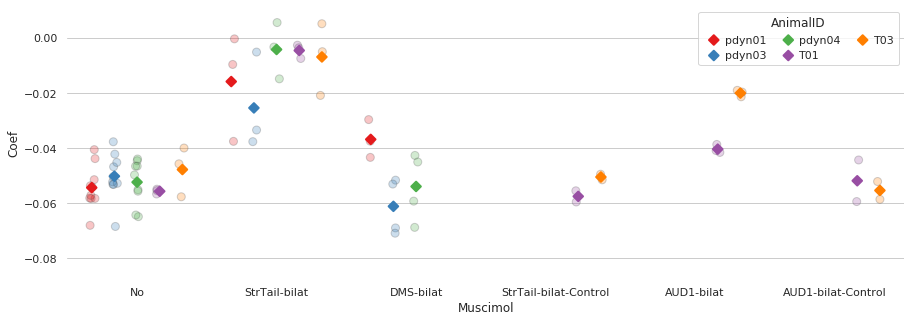

In [277]:
sns.set_style('whitegrid')
# Initialize the figure for only the coeficients
fig, ax = plt.subplots(figsize=(15,5))
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="Muscimol", y="Coef", hue="AnimalID",
              data=coefs_df, dodge=True, jitter=True,
              alpha=.25, zorder=1, size=8, palette=my_palette,
              linewidth=1)

# Show the conditional means
sns.pointplot(x="Muscimol", y="Coef", hue="AnimalID",
              data=coefs_df, dodge=.65, join=False, palette=my_palette,
              markers="D", scale=1, ci=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[len(AnimalList):], labels[len(AnimalList):], title="AnimalID",
          handletextpad=0, columnspacing=1,
          loc="top right", ncol=3, frameon=True)
plt.savefig(data_directory + 'coefficients_byMuscimol.pdf', transparent=True, bbox_inches='tight')
plt.show()

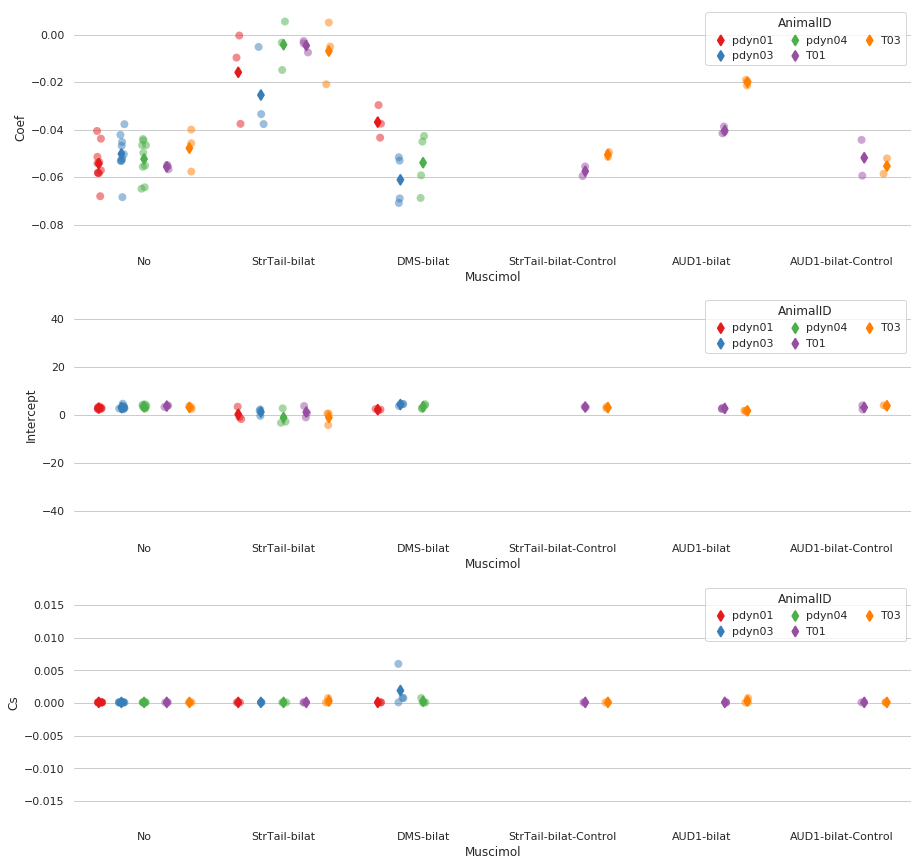

In [278]:
# plot results for all the parameters
# plot this C_s to see if the data needs regularization (if they are small they don't need it)
param_order = ['Coef', 'Intercept', 'Cs']
# Initialize the figure
fig, axs = plt.subplots(len(param_order), 1, figsize=(15, len(param_order) * 5), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace=.2, wspace=2)
axs = axs.ravel()
sns.despine(bottom=True, left=True)

for counter, ax in enumerate(axs):
    #ax.text(50, 100, param_order[counter], horizontalalignment='center', fontsize=14, fontweight='bold')
    # Show each observation with a scatterplot
    sns.stripplot(x="Muscimol", y=param_order[counter], hue="AnimalID",
                  data=coefs_df, dodge=True, jitter=True,
                  alpha=.5, zorder=1, size=8, palette=my_palette, ax=ax)

    # Show the conditional means
    sns.pointplot(x="Muscimol", y=param_order[counter], hue="AnimalID",
                  data=coefs_df, dodge=.65, join=False, palette=my_palette,
                  markers="d", scale=1, ci=None, ax=ax)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[len(AnimalList):], labels[len(AnimalList):], title="AnimalID",
              handletextpad=0, columnspacing=1,
              loc="top right", ncol=3, frameon=True)
axs[1].set_ylim(-50,50)
plt.show()

***
##### Effects of previous choice
***

In [11]:
df_to_plot.keys()

Index(['AnimalID', 'ExperimentalGroup', 'SessionTime', 'FullSessionTime',
       'Protocol', 'Stimulation', 'Muscimol', 'CenterPortDuration',
       'Contingency', 'RewardAmount', 'TrialIndex', 'TrialHighPerc',
       'Outcomes', 'OptoStim', 'FirstPokeCorrect', 'FirstPoke', 'TrialSide',
       'TrialSequence', 'ResponseTime', 'TrialStartTimestamp',
       'CumulativePerformance', 'SwitchSide', 'PreviousChoice', 'TrialEvents',
       'TrialStates', 'SessionID', 'CumulativeTrialNumber',
       'CumulativeTrialNumberByProtocol', 'CurrentPastPerformance',
       'NoOfCenterPokes', 'MiddleWaitTime', 'TrialInitiationTime', 'RightBias',
       'TrialsSpeed'],
      dtype='object')

In [12]:
# add information about the previous trial
df_to_plot['PrevTrialSuccess'] = np.insert(np.array(df_to_plot['FirstPokeCorrect'][:-1]), 0, np.nan)

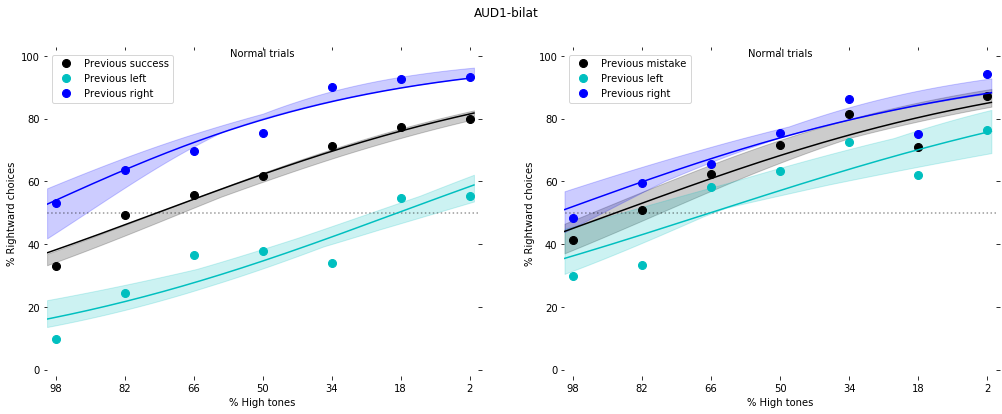

In [24]:
animal = 'T03'
muscimol_condition = 'AUD1-bilat'

# plot
# generate a list of the conditions, colors and labels
CondList = [(df_to_plot['PrevTrialSuccess']==1),
            (df_to_plot['PrevTrialSuccess']==1) & (df_to_plot['PreviousChoice']==1),
            (df_to_plot['PrevTrialSuccess']==1) & (df_to_plot['PreviousChoice']==2),
            (df_to_plot['PrevTrialSuccess']==0),
            (df_to_plot['PrevTrialSuccess']==0) & (df_to_plot['PreviousChoice']==1),
            (df_to_plot['PrevTrialSuccess']==0) & (df_to_plot['PreviousChoice']==2)]
ColorList = ['k', 'c', 'b', 'k', 'c', 'b']
LabelList = ['Previous success', 'Previous left', 'Previous right', 'Previous mistake', 'Previous left', 'Previous right']
AxsOrder = [0,0,0,1,1,1]
SubplotTitles = ['Normal trials', 'Normal trials']
# plot
fig, axs = plt.subplots(1,2,figsize=(17, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.3)
for i, ax in enumerate(axs):
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
    ax.text(50,100, SubplotTitles[i], horizontalalignment='center')
for i, condition in enumerate(CondList):
    more_conditions = (df_to_plot['Muscimol'] == muscimol_condition) & (df_to_plot['AnimalID'] == animal)
    predictDif, PsyPer, fakePredictions, predictPer, EB =\
    cuf.PP_ProcessExperiment(df_to_plot[condition & more_conditions], 5, None)#5, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = None)
for ax in axs:
    ax.legend(loc='upper left')
plt.suptitle(muscimol_condition)
plt.show(fig)

In [20]:
# do this systematically calculating the coefficients
prev_trial_df = pd.DataFrame(columns=['AnimalID', 'Muscimol_Condition', 'PrevTrialSuccess', 'PreviousChoice',\
                                      'Coef', 'Intercept'])
for animal in df_to_plot.AnimalID.unique():
    for muscond in df_to_plot.Muscimol.unique():
        for pts in [0,1]:
            for pc in [1,2]:
                df = df_to_plot[(df_to_plot.AnimalID == animal) &
                                (df_to_plot.Muscimol == muscond) &
                                (df_to_plot.PrevTrialSuccess == pts) &
                                (df_to_plot.PreviousChoice == pc)]

                predictDif, PsyPer, fakePredictions, predictPer, _ = cuf.PP_ProcessExperiment(df, None)
                if PsyPer:
                    # calculate the intercept of 50/50 chance
                    logit_midpoint = 1 / (1 + np.exp(-0.5))
                    x_midpoint = (logit_midpoint - PsyPer['Logit'].intercept_) / PsyPer['Logit'].coef_
                    # append to df
                    prev_trial_df = prev_trial_df.append({
                        'AnimalID': animal,
                        'Muscimol_Condition': muscond,
                        'PrevTrialSuccess': pts,
                        'PreviousChoice': pc,
                        'Coef': PsyPer['Logit'].coef_[0][0],
                        'Intercept': x_midpoint
                    }, ignore_index=True)

In [23]:
prev_trial_df[prev_trial_df.Muscimol_Condition == muscimol_condition]


,AnimalID,Muscimol_Condition,PrevTrialSuccess,PreviousChoice,Coef,Intercept
48,T01,AUD1-bilat,0,1,-0.025253,[[34.164548833807615]]
49,T01,AUD1-bilat,0,2,-0.031846,[[50.730148743524076]]
50,T01,AUD1-bilat,1,1,-0.036925,[[24.008853098051834]]
51,T01,AUD1-bilat,1,2,-0.058853,[[63.56722770369926]]
68,T03,AUD1-bilat,0,1,-0.017708,[[30.95362871292251]]
69,T03,AUD1-bilat,0,2,-0.019982,[[70.83664338821896]]
70,T03,AUD1-bilat,1,1,-0.020291,[[-12.056614207376397]]
71,T03,AUD1-bilat,1,2,-0.025141,[[79.5556598643423]]


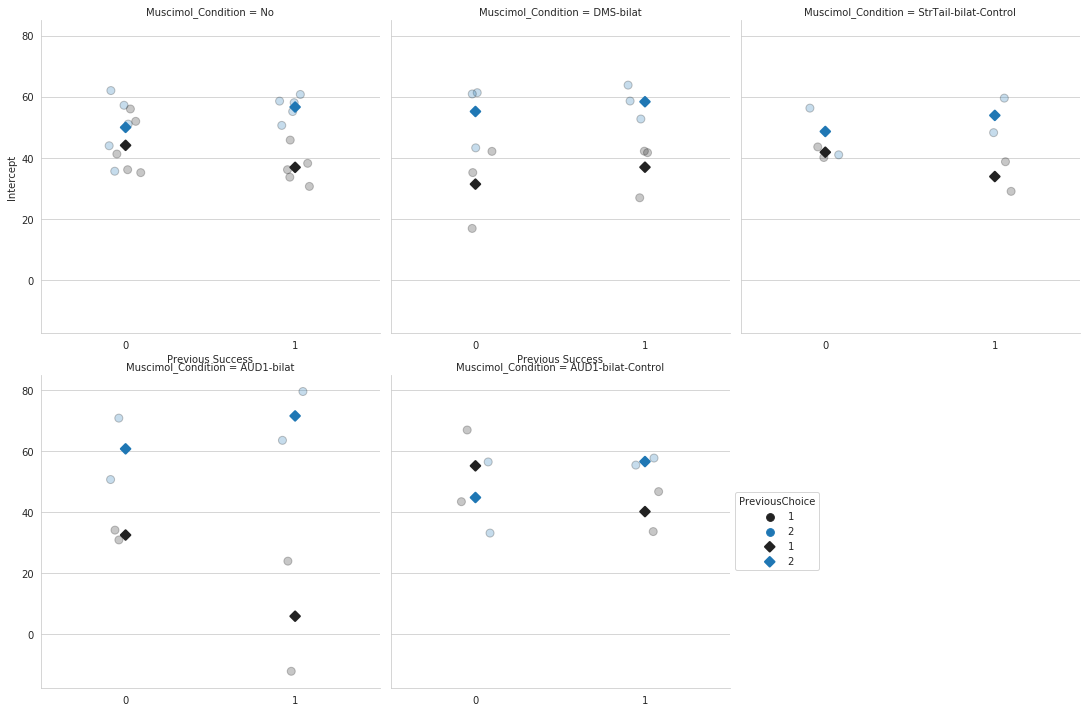

In [104]:
value_to_plot = 'Intercept'
sns.set_style('whitegrid')
grid = sns.FacetGrid(prev_trial_df[prev_trial_df.Muscimol_Condition != 'StrTail-bilat'], col="Muscimol_Condition", sharex=False, sharey=True, height=5, col_wrap=3)
grid = grid.map_dataframe(sns.stripplot, x="PrevTrialSuccess", y=value_to_plot, hue="PreviousChoice", dodge=False, jitter=True,
                          alpha=.25, zorder=1, size=8,
                          linewidth=1)
grid = grid.map_dataframe(sns.pointplot, x="PrevTrialSuccess", y=value_to_plot, hue="PreviousChoice",
                          dodge=0, join=False,
                          markers="D", scale=1, ci=None)
plt.legend(loc='center left',bbox_to_anchor=(1,0.5), title="PreviousChoice")
grid.axes[0].set_xlabel('Previous Success')
grid.axes[1].set_xlabel('Previous Success')
grid.axes[0].set_ylabel(value_to_plot)
plt.savefig(data_directory + 'EffectOfPreviousTrial_' + value_to_plot + '.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

***
#####  Make another model that gets as inputs not only the difficulty, but also the previous trial choice and outcome
This will model everything together


In [14]:
from sklearn.linear_model import LogisticRegressionCV
diffs = np.array(df_to_plot['TrialHighPerc'])
choices = np.array(df_to_plot['FirstPoke'])
prevtrial = np.array(df_to_plot['PreviousChoice'])
# masks to remove nans for logistic regression
nan_mask = ~(np.isnan(diffs) | np.isnan(choices) | np.isnan(prevtrial))
xs = np.column_stack((diffs[nan_mask], prevtrial[nan_mask]))
# logistic regression
mdl = LogisticRegressionCV().fit(xs, choices[nan_mask])
mdl.coef_

array([[-0.0475165 ,  1.15958583]])

***
#####  Effect of past choices

In [18]:
# calculate the effects of choices in the past
choices = df_to_plot['FirstPoke']
# past choice
xs = np.insert(np.asfarray(choices[:-1]), 0, np.nan)[:, np.newaxis]
for i in range(10):
    xs = np.column_stack((xs, np.insert(np.asfarray(xs[:-1, xs.shape[1]-1]), 0, np.nan)))
        
nan_mask = ~ (np.isnan(xs).any(axis=1) | np.isnan(choices))
# logistic regression
mdl = LogisticRegressionCV().fit(xs[nan_mask,:], choices[nan_mask])
mdl.coef_

array([[0.65755759, 0.37014969, 0.22288924, 0.16890186, 0.13369763,
        0.15650213, 0.11896886, 0.14487979, 0.12946439, 0.14041301,
        0.23272749]])

***
#####  Reaction times, etc


In [10]:
# explore reaction times, speed, number of trials, pokes in the center, etc
df_to_plot.keys()

Index(['AnimalID', 'ExperimentalGroup', 'SessionTime', 'FullSessionTime',
       'Protocol', 'Stimulation', 'Muscimol', 'CenterPortDuration',
       'Contingency', 'RewardAmount', 'TrialIndex', 'TrialHighPerc',
       'Outcomes', 'OptoStim', 'FirstPokeCorrect', 'FirstPoke', 'TrialSide',
       'TrialSequence', 'ResponseTime', 'TrialStartTimestamp',
       'CumulativePerformance', 'SwitchSide', 'PreviousChoice', 'TrialEvents',
       'TrialStates', 'SessionID', 'CumulativeTrialNumber',
       'CumulativeTrialNumberByProtocol', 'CurrentPastPerformance',
       'NoOfCenterPokes', 'MiddleWaitTime', 'TrialInitiationTime', 'RightBias',
       'TrialsSpeed'],
      dtype='object')

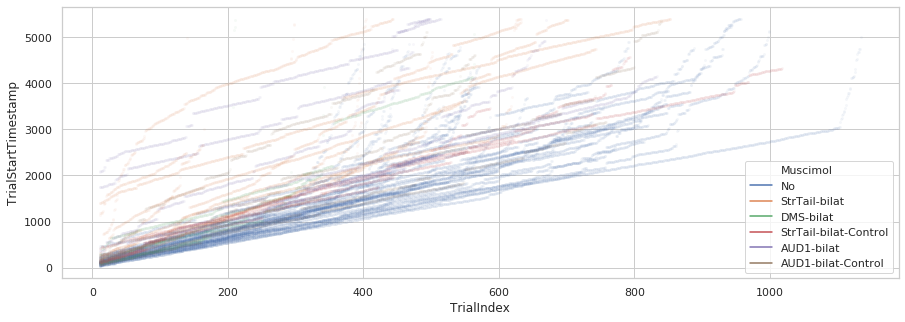

In [207]:
# plot the number of trials per session as a function of time
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='TrialIndex', y='TrialStartTimestamp',
             data=df_to_plot,
             ax=ax, hue='Muscimol', 
             marker=".", alpha=0.05, markeredgewidth=0, linewidth=0,
             # the following line splits the data and does not compute confidence intervals and mean
             units="AnimalID", estimator=None)

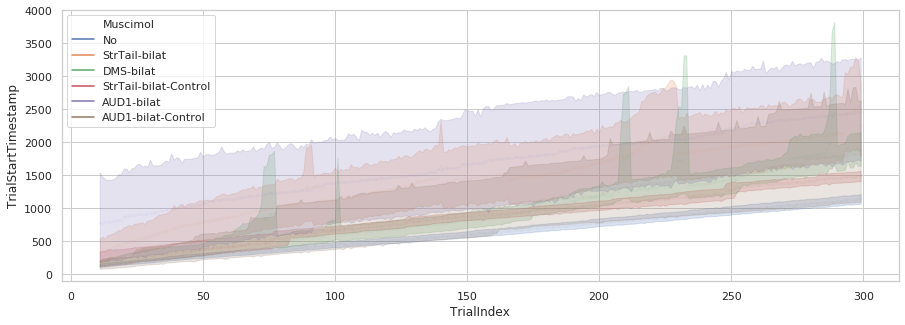

In [38]:
# plot the number of trials per session as a function of time
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='TrialIndex', y='TrialStartTimestamp',
             data=df_to_plot[df_to_plot.TrialIndex < 300],
             ax=ax, hue='Muscimol', 
             marker=".", alpha=0.05, markeredgewidth=0, linewidth=0)
             # the following line splits the data and does not compute confidence intervals and mean
             #units="AnimalID", estimator=None)

In [260]:
# Calculate speed over the surrounding 20 trials
SP_WINDOW = 20
speed_list = []
for Sid in pd.unique(df_to_plot['SessionID']):
    speed_list.append(cuf.speed_window_calculator(df_to_plot[df_to_plot['SessionID']==Sid], SP_WINDOW))
# flatten the list of lists
df_to_plot['TrialsSpeed'] = np.array(list(chain(*[x for x in speed_list])))

In [ ]:
# plot the speed per session as a function of time
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='TrialIndex', y='TrialsSpeed',
             data=df_to_plot[df_to_plot.SessionID==session],
             ax=ax, hue='Muscimol', 
             marker=".", alpha=1, markeredgewidth=0, linewidth=0,
             # the following line splits the data and does not compute confidence intervals and mean
             units="AnimalID", estimator=None)

***
#### Analyze speed during distinct times of the trial
***

In [46]:
df_to_plot.keys()

Index(['AnimalID', 'CenterPortDuration', 'Contingency',
       'CumulativePerformance', 'ExperimentalGroup', 'FirstPoke',
       'FirstPokeCorrect', 'FullSessionTime', 'Muscimol', 'OptoStim',
       'Outcomes', 'PreviousChoice', 'Protocol', 'ResponseTime',
       'RewardAmount', 'RewardChange', 'RewardChangeBlock', 'SessionTime',
       'Stimulation', 'SwitchSide', 'TrialEvents', 'TrialHighPerc',
       'TrialIndex', 'TrialSequence', 'TrialSide', 'TrialStartTimestamp',
       'TrialStates', 'SessionID', 'CumulativeTrialNumber',
       'CumulativeTrialNumberByProtocol', 'CurrentPastPerformance',
       'NoOfCenterPokes', 'MiddleWaitTime', 'TrialInitiationTime', 'RightBias',
       'TrialsSpeed', 'PrevTrialSuccess'],
      dtype='object')

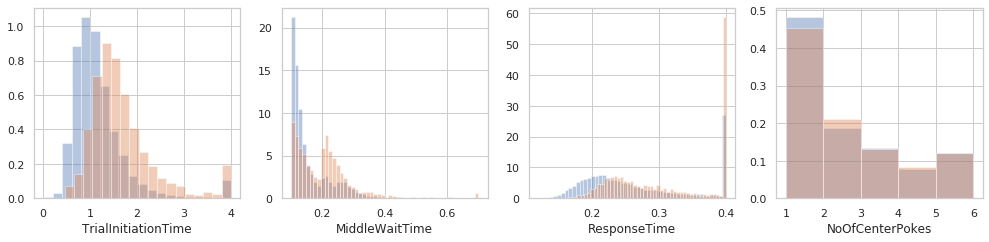

In [55]:
# subselect those trials where the previous one was a success (to avoid being influenced by the punishment)
df = df_to_plot[df_to_plot.PrevTrialSuccess == 1]


# collapse values
df.loc[df.TrialInitiationTime > 4, 'TrialInitiationTime'] = 4
df.loc[df.MiddleWaitTime > .7, 'MiddleWaitTime'] = .7
df.loc[df.ResponseTime > .4, 'ResponseTime'] = .4
df.loc[df.NoOfCenterPokes > 6, 'NoOfCenterPokes'] = 6


sns.set_style('whitegrid')
fig, axs = plt.subplots(1, 4, figsize=(17, 3.5))
ax = axs.ravel()

sns.distplot(df[df.Muscimol == 'No'].TrialInitiationTime, kde=False, ax=ax[0], bins=20, norm_hist=True)
sns.distplot(df[df.Muscimol == 'StrTail-bilat'].TrialInitiationTime, kde=False, ax=ax[0], bins=20, norm_hist=True)

sns.distplot(df[df.Muscimol == 'No'].MiddleWaitTime, kde=False, ax=ax[1], bins=50, norm_hist=True)
sns.distplot(df[df.Muscimol == 'StrTail-bilat'].MiddleWaitTime, kde=False, ax=ax[1], bins=50, norm_hist=True)

sns.distplot(df[df.Muscimol == 'No'].ResponseTime, kde=False, ax=ax[2], bins=50, norm_hist=True)
sns.distplot(df[df.Muscimol == 'StrTail-bilat'].ResponseTime, kde=False, ax=ax[2], bins=50, norm_hist=True)

sns.distplot(df[df.Muscimol == 'No'].NoOfCenterPokes, kde=False, ax=ax[3], bins=5, norm_hist=True)
sns.distplot(df[df.Muscimol == 'StrTail-bilat'].NoOfCenterPokes, kde=False, ax=ax[3], bins=5, norm_hist=True)

plt.savefig(data_directory + 'Times.pdf',
            transparent=True, bbox_inches='tight')

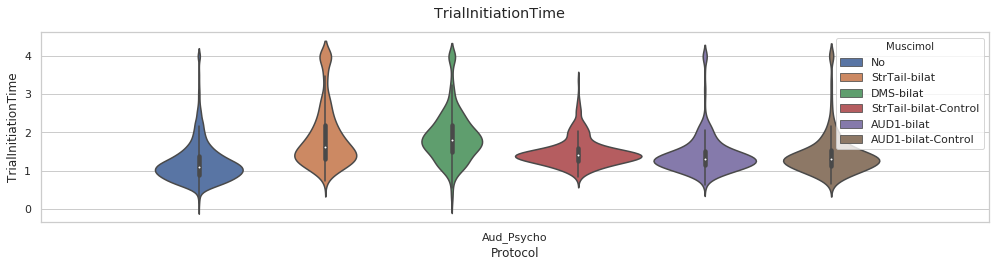

In [74]:
column_to_plot = 'TrialInitiationTime'
#xsplit = 'TrialSequence' # for trial difficulty
xsplit = 'Protocol'
# subselect those trials where the previous one was a success (to avoid being influenced by the punishment
df = df_to_plot[df_to_plot.PrevTrialSuccess == 1]
# Modify the TrialSequence column as the difficulty
df.loc[df.TrialSequence == 7, 'TrialSequence'] = 1
df.loc[df.TrialSequence == 6, 'TrialSequence'] = 2
df.loc[df.TrialSequence == 5, 'TrialSequence'] = 3
# select only the first 200 trials of the session
df = df[df.TrialIndex<200]
df.loc[df[column_to_plot] > 4, column_to_plot] = 4
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(17, 3.5))
sns.violinplot(x = xsplit, y = column_to_plot, hue='Muscimol', data = df)
#plt.gca().set_xlabel('Difficulty')
plt.suptitle(column_to_plot)
plt.savefig(data_directory + column_to_plot + '.pdf',
            transparent=True, bbox_inches='tight')

***
#### Test the effects of the reward block
***

In [7]:
df_to_plot = AnimalsDF

In [8]:
# select those with the 3x block switch
df_to_plot = df_to_plot[df_to_plot.RewardChange == '3x Block Switch']

Progress: [####################] 100.0%


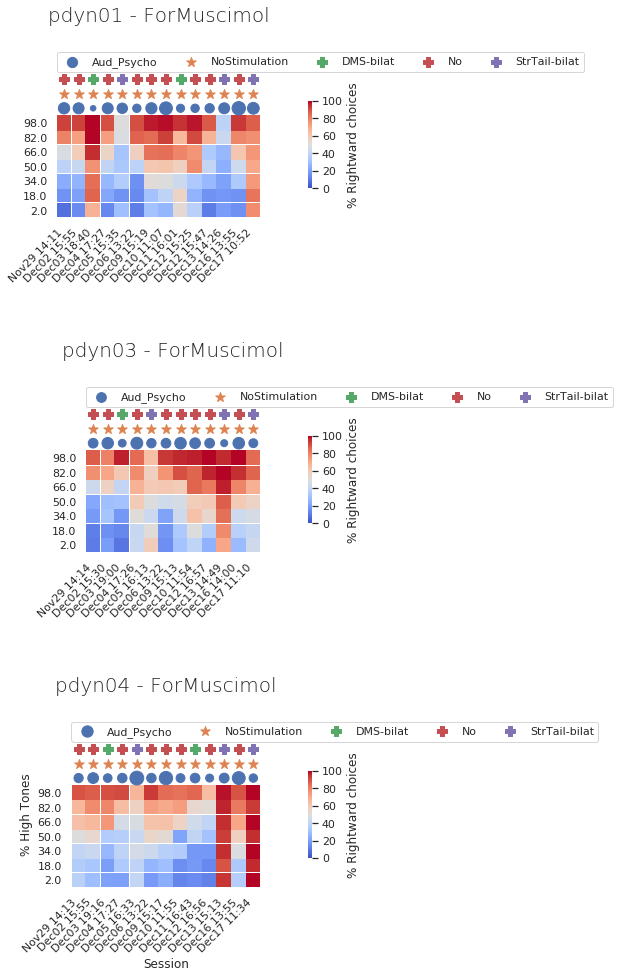

In [9]:
fig, ax = plt.subplots(len(pd.unique(df_to_plot.AnimalID)), 1, figsize=(17,5 * len(pd.unique(df_to_plot.AnimalID))))
axs = ax.ravel()
fig.subplots_adjust(hspace=1.3)
for i, animal in enumerate(pd.unique(df_to_plot.AnimalID)):
    aDF = df_to_plot[df_to_plot.AnimalID == animal]
    dfToPlot = plot_utils.summary_matrix(aDF)
    axs[i] = plot_utils.summary_plot(dfToPlot, aDF, axs[i])

Progress: [####################] 100.0%


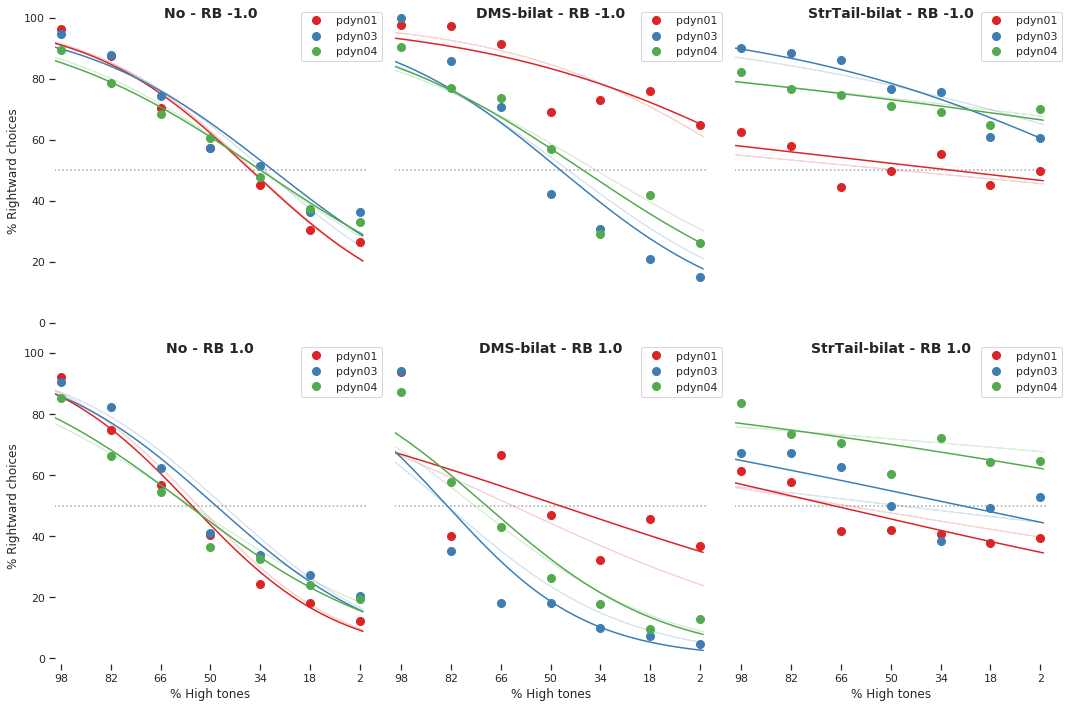

In [11]:
# plot psychometric curves THIS IS VERY CONFUSING LIKE THIS



# prepare colors
my_palette = "Set1"
AnimalList = list(df_to_plot.AnimalID.unique())
ColorList = sns.color_palette(my_palette, n_colors=len(AnimalList), desat=.9)

fig, axs = plt.subplots(2, math.ceil(len(df_to_plot.Muscimol.unique())), figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.2, wspace=2)
axs = axs.ravel()
for ax in axs:
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)

#for each of the blocks
axcount = 0
for rcb in df_to_plot.RewardChangeBlock.unique():
    df = df_to_plot[df_to_plot.RewardChangeBlock == rcb]

    for muscimol_condition in df.Muscimol.unique():
        ax = axs[axcount]
        ax.text(50, 100, muscimol_condition + ' - RB ' + str(rcb), horizontalalignment='center', fontsize=14, fontweight='bold')
        for animal in df[df.Muscimol == muscimol_condition].AnimalID.unique():
            conditions = (df['AnimalID'] == animal) & (df['Muscimol'] == muscimol_condition)
            # if there are enough trials
            if df[conditions].shape[0] > 3:
                predictDif, PsyPer, fakePredictions, predictPer, _ = \
                cuf.PP_ProcessExperiment(df[conditions], 1)
                plot_utils.PlotPsychPerformance(dataDif=PsyPer['Difficulty'], dataPerf=PsyPer['Performance'],
                                                predictDif=predictDif, ax=ax, fakePred=fakePredictions,
                                                realPred=predictPer, label=animal,
                                                color=ColorList[AnimalList.index(animal)])

        #ax.get_legend().remove()
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
        plt.tight_layout()
        
        axcount+=1

        update_progress(axcount / len(df_to_plot.RewardChangeBlock.unique()))
    
update_progress(1)
plt.savefig(data_directory + 'psychometricPerformance_RewardBlockSwitch.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [12]:
# create a vector with the trial index in the block
block_trial_index_vector = []
for session in df_to_plot.SessionID.unique():
    # restart the counter
    bti_counter = 1
    df = df_to_plot[df_to_plot.SessionID == session]
    # keep track of the previous block
    previous_block = 999
    for trial in range(df.shape[0]):
        block = df.iloc[trial].RewardChangeBlock
        if block != previous_block: # restart counter
            bti_counter = 1
        else:
            bti_counter += 1
        previous_block = block
        block_trial_index_vector.append(bti_counter)

In [24]:
#select only a certain number of trials after the block switch
xtr_inblock = 75
df_to_plot_overxblock = df_to_plot[np.array(block_trial_index_vector) > xtr_inblock]

Progress: [####################] 100.0%


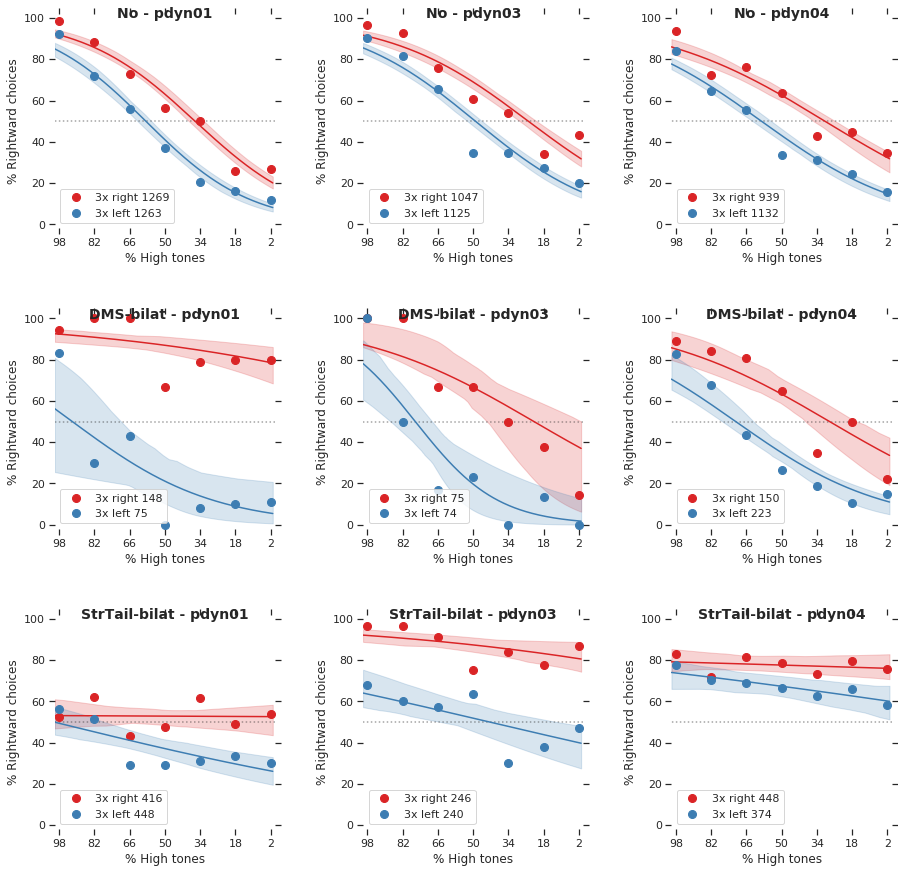

In [25]:
# plot per animal and per muscimol condition
nanims = len(df_to_plot_overxblock.AnimalID.unique())
nmus = len(df_to_plot_overxblock.Muscimol.unique())
labellist = ['3x right', '3x left']
fig, axs = plt.subplots(nanims, nmus, figsize=(5 * nmus , 5 * nanims), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.4, wspace=.4)
axs = axs.ravel()
for ax in axs:
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)

axcounter = 0
for muscimol_condition in df_to_plot_overxblock.Muscimol.unique():
    musdf = df_to_plot_overxblock[df_to_plot_overxblock.Muscimol == muscimol_condition]
    for animal in musdf.AnimalID.unique():
        andf = musdf[musdf.AnimalID == animal]
        for rcbcounter, rcb in enumerate(np.sort(andf.RewardChangeBlock.unique())):
            ax = axs[axcounter]
            df = andf[andf.RewardChangeBlock == rcb]
            # if there are enough trials
            if df.shape[0] > 3:
                predictDif, PsyPer, fakePredictions, predictPer, _ = cuf.PP_ProcessExperiment(df, 50)
                plot_utils.PlotPsychPerformance(dataDif=PsyPer['Difficulty'], dataPerf=PsyPer['Performance'],
                                                predictDif=predictDif, ax=ax, fakePred=fakePredictions,
                                                realPred=predictPer,
                                                label=labellist[rcbcounter] + ' ' + str(df.shape[0]),
                                                color=ColorList[rcbcounter])
        ax.text(50, 100, muscimol_condition + ' - ' + animal, horizontalalignment='center', fontsize=14, fontweight='bold')
        ax.legend(loc='lower left')
        update_progress(axcounter / len(axs))
        axcounter += 1

update_progress(1)
plt.savefig(data_directory + 'psychometricPerformance_RewardBlockSwitch_' + str(xtr_inblock) + '-trialsInBlock.pdf', transparent=True, bbox_inches='tight')

***
***
#### Analyze the effects after changing the contingency
***

In [169]:
df_to_plot = AnimalsDF

Progress: [####################] 100.0%


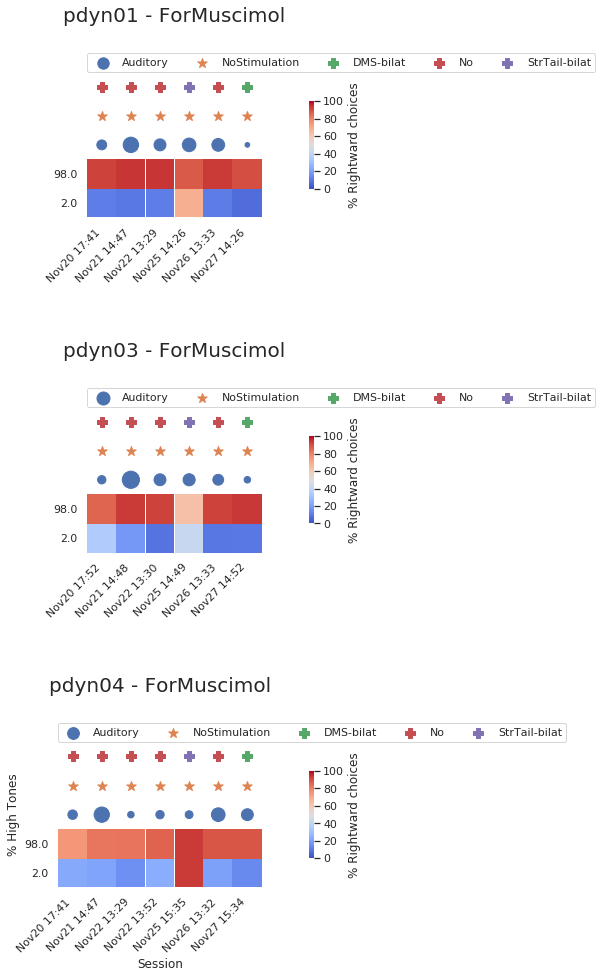

In [177]:
fig, ax = plt.subplots(len(pd.unique(df_to_plot.AnimalID)), 1, figsize=(17,5 * len(pd.unique(df_to_plot.AnimalID))))
axs = ax.ravel()
fig.subplots_adjust(hspace=1.3)
for i, animal in enumerate(pd.unique(df_to_plot.AnimalID)):
    aDF = df_to_plot[df_to_plot.AnimalID == animal]
    dfToPlot = plot_utils.summary_matrix(aDF)
    axs[i] = plot_utils.summary_plot(dfToPlot, aDF, axs[i])

In [175]:
# Use this to see the session IDs for a particular animal and select the ones you want
df_to_plot[df_to_plot.AnimalID == 'pdyn04'].SessionID.unique()

array(['pdyn04 Jul08 14:50', 'pdyn04 Jul10 16:19', 'pdyn04 Jul11 15:55',
       'pdyn04 Jul12 10:39', 'pdyn04 Jul15 13:34', 'pdyn04 Jul16 13:56',
       'pdyn04 Jul17 14:59', 'pdyn04 Jul18 13:29', 'pdyn04 Jul19 13:26',
       'pdyn04 Sep09 17:36', 'pdyn04 Sep10 16:14', 'pdyn04 Sep11 14:37',
       'pdyn04 Sep12 12:50', 'pdyn04 Sep13 14:31', 'pdyn04 Sep16 16:36',
       'pdyn04 Sep28 15:24', 'pdyn04 Sep30 14:46', 'pdyn04 Oct01 15:50',
       'pdyn04 Oct02 16:17', 'pdyn04 Oct03 14:25', 'pdyn04 Oct08 14:50',
       'pdyn04 Oct09 16:42', 'pdyn04 Oct10 13:46', 'pdyn04 Oct11 16:32',
       'pdyn04 Oct14 15:13', 'pdyn04 Oct15 16:13', 'pdyn04 Oct16 14:26',
       'pdyn04 Oct17 14:58', 'pdyn04 Oct18 12:57', 'pdyn04 Oct21 14:25',
       'pdyn04 Oct22 14:41', 'pdyn04 Oct23 14:43', 'pdyn04 Oct24 14:47',
       'pdyn04 Oct25 13:46', 'pdyn04 Oct28 13:59', 'pdyn04 Oct28 14:20',
       'pdyn04 Oct29 14:21', 'pdyn04 Oct30 13:22', 'pdyn04 Oct31 17:06',
       'pdyn04 Nov01 10:36', 'pdyn04 Nov05 16:36', 

In [176]:
# select particular sessions to keep
sessionIDs_tokeep = ['pdyn01 Nov20 17:41', 'pdyn01 Nov21 14:47', 'pdyn01 Nov22 13:29',
                     'pdyn01 Nov25 14:26', 'pdyn01 Nov26 13:33', 'pdyn01 Nov27 14:26',
                     'pdyn03 Nov20 17:52', 'pdyn03 Nov21 14:48',
       'pdyn03 Nov22 13:30', 'pdyn03 Nov25 14:49', 'pdyn03 Nov26 13:33',
       'pdyn03 Nov27 14:52', 'pdyn04 Nov20 17:41',
       'pdyn04 Nov21 14:47', 'pdyn04 Nov22 13:29', 'pdyn04 Nov22 13:52',
       'pdyn04 Nov25 15:35', 'pdyn04 Nov26 13:32', 'pdyn04 Nov27 15:34'
    
]


df_to_plot = df_to_plot[(df_to_plot['SessionID'].isin(sessionIDs_tokeep))]

In [178]:
# restrict the count to 1.5 hours
hours_cut_off = 1.5
df_to_plot = df_to_plot[df_to_plot['TrialStartTimestamp'] < hours_cut_off * 60 * 60]

Progress: [####################] 100.0%


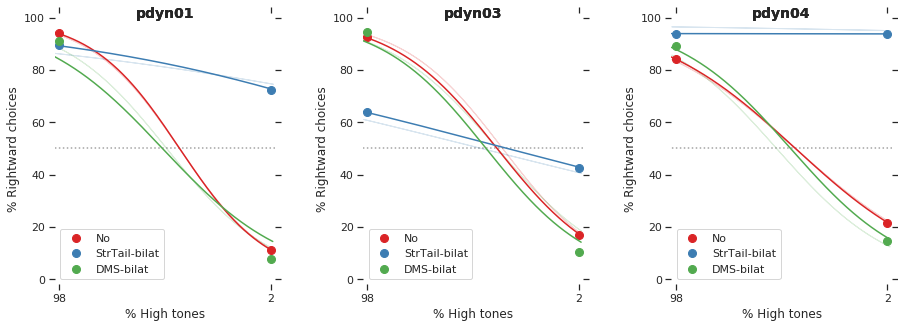

In [184]:
# plot per animal and per muscimol condition
nanims = len(df_to_plot.AnimalID.unique())
nmus = len(df_to_plot.Muscimol.unique())
fig, axs = plt.subplots(1, nanims, figsize=(5 * nanims, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.4, wspace=.4)
axs = axs.ravel()
for ax in axs:
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)

axcounter = 0
for animal in df_to_plot.AnimalID.unique():
    andf = df_to_plot[df_to_plot.AnimalID == animal]
    ax = axs[axcounter]
    axcounter += 1
    for muscounter, muscimol_condition in enumerate(andf.Muscimol.unique()):
        df = andf[andf.Muscimol == muscimol_condition]
        predictDif, PsyPer, fakePredictions, predictPer, _ = cuf.PP_ProcessExperiment(df, 1)
        plot_utils.PlotPsychPerformance(dataDif=PsyPer['Difficulty'], dataPerf=PsyPer['Performance'],
                                        predictDif=predictDif, ax=ax, fakePred=fakePredictions,
                                        realPred=predictPer, label=muscimol_condition,
                                        color=ColorList[muscounter])
        ax.text(50, 100, animal, horizontalalignment='center', fontsize=14, fontweight='bold')
        ax.legend(loc='lower left')
    update_progress(axcounter / len(axs))

update_progress(1)

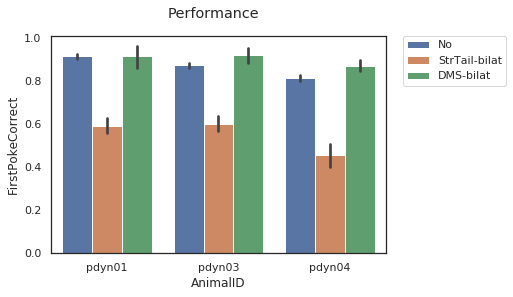

In [192]:
sns.barplot(x='AnimalID', y='FirstPokeCorrect', hue='Muscimol', data=df_to_plot, n_boot=1000)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
tt = plt.suptitle('Performance')

plt.savefig(data_directory + 'CorrectTrials_ReversedContingency_byMuscimol.pdf', transparent=True,
            bbox_extra_artists=(lgd,tt), bbox_inches='tight')

### Test stuff

(array([[0.1830965]]),
 array([-3.66192979]),
 array([0.00077426]),
 'lbfgs',
 array([[23.39962298]]))

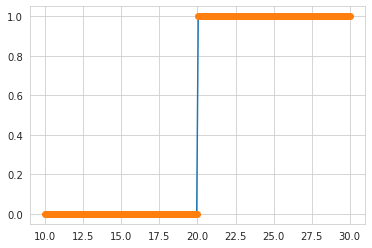

In [109]:
import sklearn.linear_model as lin
val = 20
xs = np.linspace(-10, 10, 200) + val
mdl = lin.LogisticRegressionCV().fit(xs[:,None], xs>val)
plt.plot(xs, mdl.predict(xs[:,None]))
plt.plot(xs, xs > val, 'o')
#calculate intercept with Maxime's correction
logit_midpoint = 1 / (1 + np.exp(-0.5))
x_midpoint = (logit_midpoint - mdl.intercept_) / mdl.coef_
mdl.coef_, mdl.intercept_, mdl.C_, mdl.solver, x_midpoint

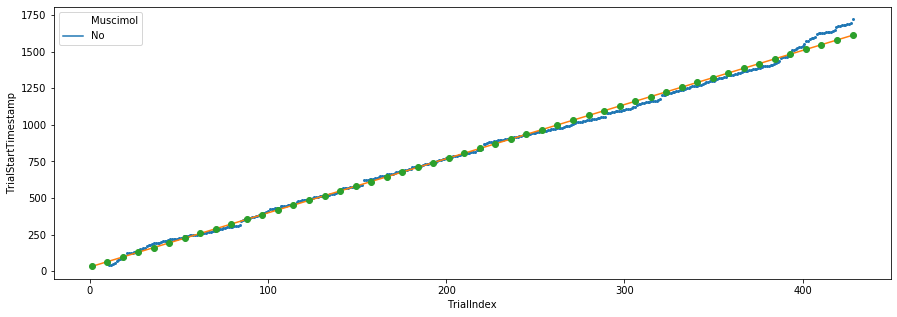

In [10]:
# test of model fitting
session = 'pdyn01 Sep30 14:52'
from sklearn.linear_model import LinearRegression
df = df_to_plot[df_to_plot.SessionID==session]
lrmodel = LinearRegression().fit(df.TrialIndex[:, np.newaxis], df.TrialStartTimestamp)
xvals = np.linspace(1,max(df.TrialIndex), 50)
preds = lrmodel.predict(xvals[:, np.newaxis])

hand_preds = [lrmodel.intercept_ + lrmodel.coef_ * x for x in xvals]

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='TrialIndex', y='TrialStartTimestamp',
             data=df_to_plot[df_to_plot.SessionID==session],
             ax=ax, hue='Muscimol', 
             marker=".", alpha=1, markeredgewidth=0, linewidth=0,
             # the following line splits the data and does not compute confidence intervals and mean
             units="AnimalID", estimator=None)
plt.plot(xvals,preds)
plt.plot(xvals,hand_preds, 'o')


In [11]:
lrmodel.coef_

array([3.69694017])